# EDA

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm
from pathlib import Path  
import re
import string
from transformers import AutoTokenizer
#add package
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt

In [25]:
# requirements 
# wordcloud
# scipy
# transformers
# tqdm
# matplotlib

In [26]:
vaccine_df_2020_2021 = pd.read_csv(r'data/vaccine_output_2020_2021.csv',index_col=0)

#vaccine_df_2021_2022 = pd.read_csv(r'data/vaccine_output_2021_2022.csv')

In [27]:
vaccine_df_2020_2021.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5000 non-null   object
 1   User       5000 non-null   object
 2   Tweet      5000 non-null   object
 3   Tweet_URL  5000 non-null   object
 4   Location   3787 non-null   object
dtypes: object(5)
memory usage: 234.4+ KB


In [28]:
print(vaccine_df_2020_2021.shape)

(5000, 5)


In [29]:
vaccine_df_2020_2021.head()

,Date,User,Tweet,Tweet_URL,Location
0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,https://twitter.com/WebAeneas/status/146835672...,NaN
2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",https://twitter.com/TheAmirImani/status/146835...,Toronto
3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


### PREPROCESSING TWEETS

In [30]:
# clean and filter using SPARK
def preprocessing(df):
    location_df = df['Location']
    tweet_lower_df = df['Tweet'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = tweet_lower_df.replace(r'\s+',' ',regex=True)
    tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_emoji_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)
    
    location_whitespace_df =  location_df.replace(r'\s+',' ',regex=True)
    location_hashtag_df = location_whitespace_df.replace(r'#','',regex=True)
    location_numbers_df = location_hashtag_df.replace(r'[0-9]+','',regex=True)
    location_emoji_df = location_numbers_df.replace(EMOJI_PATTERN,'',regex = True)
    PUNCT_MODIFIED = r'[.|!|#|\"|$|%|\'|\(|\)|*|+|=|<|>|~|\{|\}|\\|/|:|;|\?|@|\[|^|_|\`|\]]'
    location_punc_df = location_emoji_df.replace(PUNCT_MODIFIED,'',regex = True)
    return tweet_punc_df,location_punc_df


In [31]:
vaccine_20_21_cleanedDF = vaccine_df_2020_2021
vaccine_20_21_cleanedDF['Processed_Tweet'],vaccine_20_21_cleanedDF['Location'] = preprocessing(vaccine_df_2020_2021)
vaccine_20_21_cleanedDF['Location'] = vaccine_20_21_cleanedDF['Location'].fillna('')

In [32]:
#Rearrange columns
col_list = vaccine_20_21_cleanedDF.columns.tolist()
cols = col_list[:-3] + col_list[-1:] + col_list[3:5]
print(cols)
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF[cols]

['Date', 'User', 'Tweet', 'Processed_Tweet', 'Tweet_URL', 'Location']


In [33]:
vaccine_20_21_cleanedDF.to_csv(r'data/new_processed.csv', encoding='utf-8')

In [34]:
vaccine_20_21_cleanedDF.head()

,Date,User,Tweet,Processed_Tweet,Tweet_URL,Location
0,2021-12-07 23:29:36+00:00,MA_CEAL,#COVIDMythBustingTuesdays! Myth: Doesn’t the #...,covidmythbustingtuesdays myth doesnt the covid...,https://twitter.com/MA_CEAL/status/14683620841...,"Boston, Massachusetts"
1,2021-12-07 23:08:19+00:00,WebAeneas,#vaccinated another great idea you can sue any...,vaccinated another great idea you can sue anyo...,https://twitter.com/WebAeneas/status/146835672...,
2,2021-12-07 23:02:41+00:00,TheAmirImani,"I don't know if this is a ""3 dose #vaccine"" or...",i dont know if this is a dose vaccine or a se...,https://twitter.com/TheAmirImani/status/146835...,Toronto
3,2021-12-07 22:58:56+00:00,michaelwbunner,Can anyone prove that the #covid #vaccine prev...,can anyone prove that the covid vaccine preven...,https://twitter.com/michaelwbunner/status/1468...,"Norristown, PA"
4,2021-12-07 22:58:46+00:00,drsajumathew,About 1600 people die each day from #COVID in ...,about people die each day from covid in the u...,https://twitter.com/drsajumathew/status/146835...,"Atlanta, GA"


(-0.5, 399.5, 199.5, -0.5)

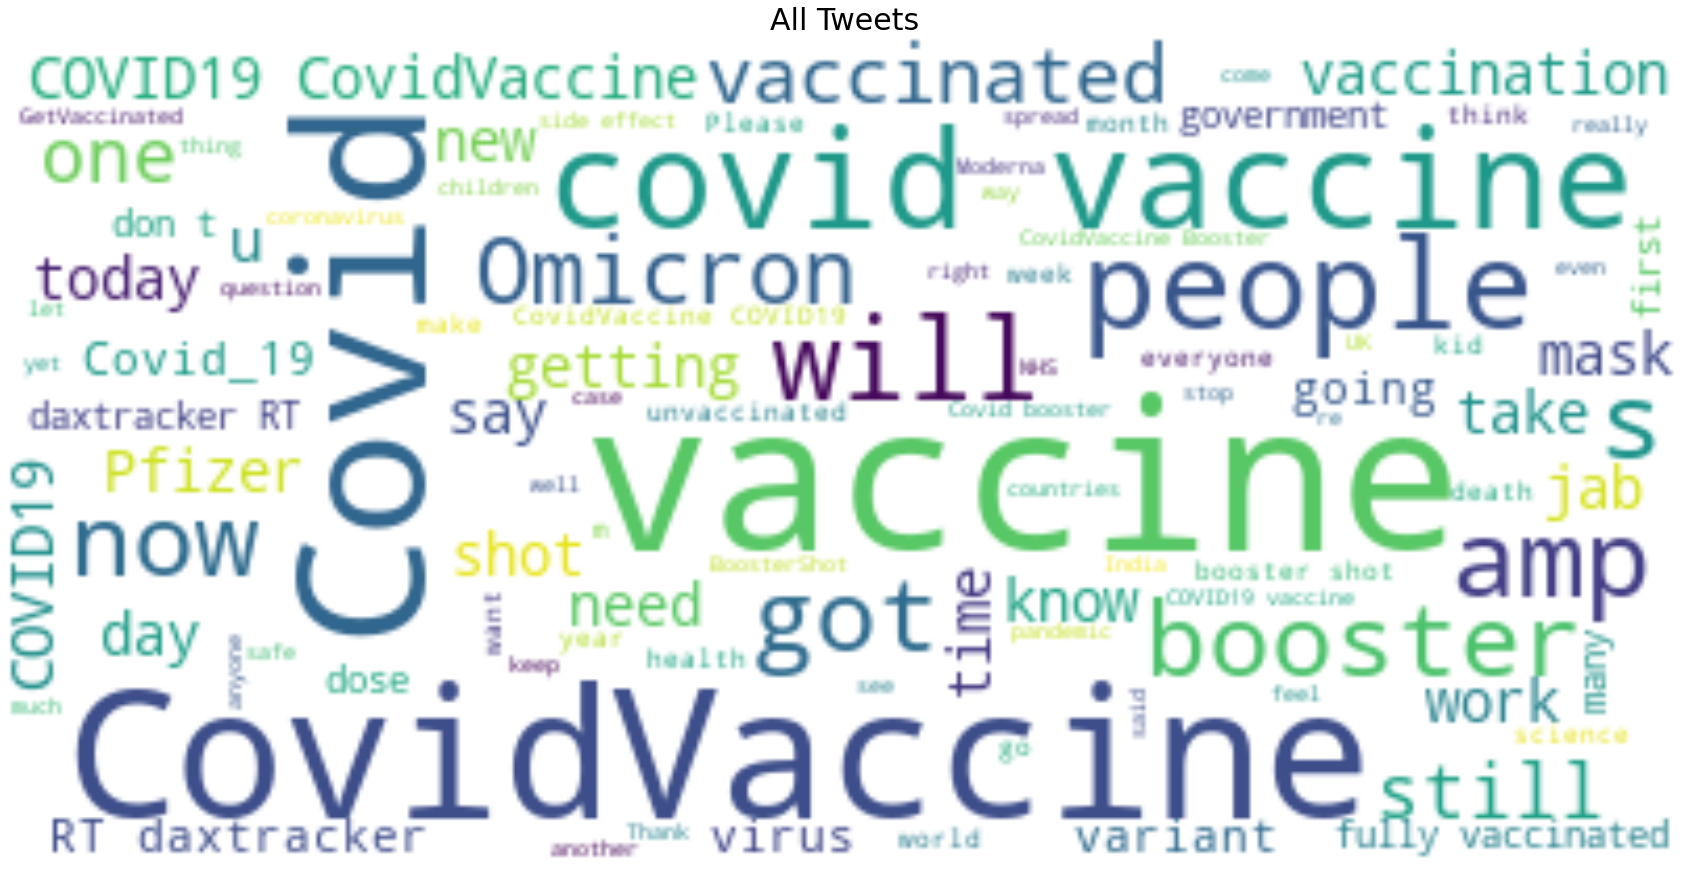

In [35]:

tweet_All = " ".join(review for review in vaccine_20_21_cleanedDF['Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')


The Most Frequent words are 'CovidVaccine , Covid , Virus , Omicron ' Occurs almost in all the sentances , this along with the stop words wouldnt affect the performance of algorithms but words like Pfizer Moderna can help us determine the popular vaccine , and words such as "side effect  , death " can help us tag misinformed tweets about covid vaccine 

## ALGORITHMS

#### Basic NLTK Operations

In [ ]:
#VADER 
#ROBERTA
#Compare and visualize 
#Pipeline for current tweet